## NISKINE dataset overview and gridding:

Description of the moorings: location, time series properties (length, time resolution, variables)

Interpolation of the data from one mooring on one grid

Comparison with previous results


In [65]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import glob
import pandas as pd
#import netcdf4 as nc
#import mplniw.utils as ut

In [2]:
root_dir = '/Users/zcasparcohen/Documents/NISKINE/data/'
os.listdir(root_dir+'v1/')

['M1_9408.nc',
 'M2_8065.nc',
 'M2_22479.nc',
 'M2_23615.nc',
 'M1_13481.nc',
 'M3_12733.nc',
 'M1_14408.nc',
 'M3_15694.nc',
 'M1_3109.nc',
 'M3_15339.nc',
 'M2_3110.nc',
 'M1_22476.nc',
 'M3_8122.nc',
 'M2_10219.nc']

### Quick overview of one ADCP

In [3]:
test = xr.open_dataset(root_dir+'v1/M1_13481.nc')
print('Time series begins on ', test.time.values[0])
print('Time series ends on ', test.time.values[-1])

Time series begins on  2019-05-13T00:00:14.999866000
Time series ends on  2020-10-13T18:28:32.963465000


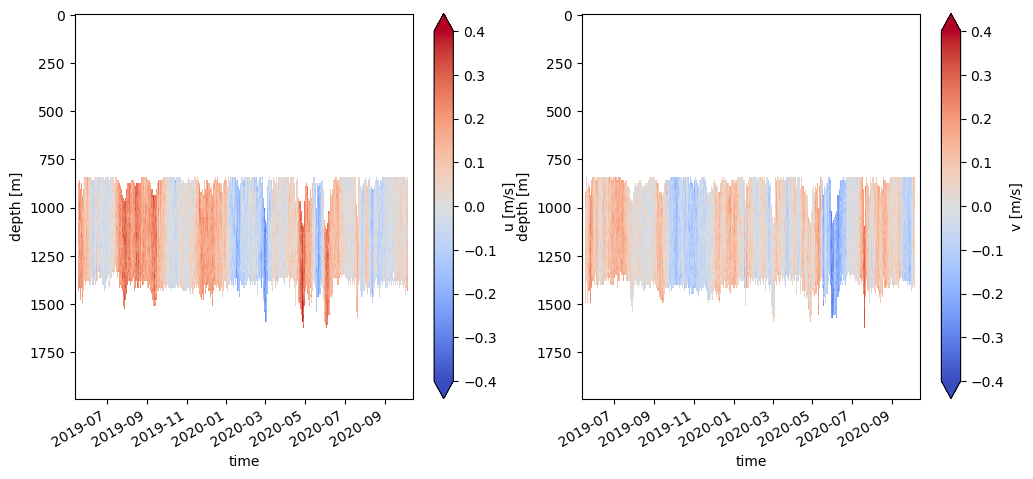

In [4]:
fig,axs=plt.subplots(1,2,figsize=(12,5))
test.u.plot(ax=axs[0],yincrease=False,vmax=0.4,cmap='coolwarm')
test.v.plot(ax=axs[1],yincrease=False,vmax=0.4,cmap='coolwarm')

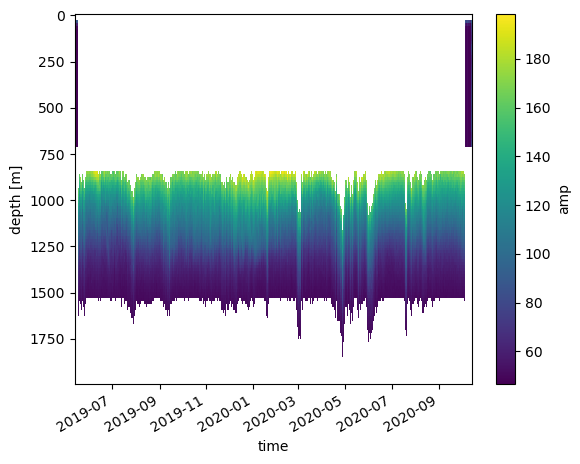

In [5]:
test.amp.plot(yincrease=False)

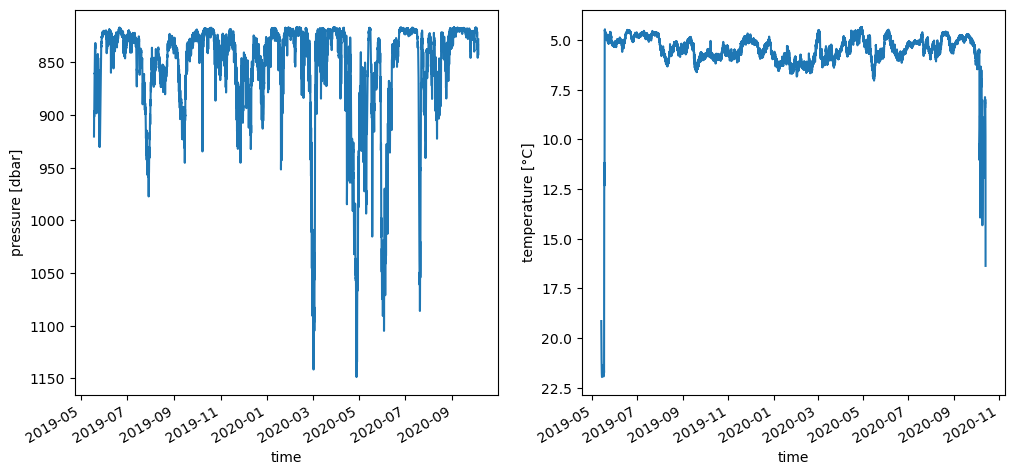

In [53]:
fig,axs=plt.subplots(1,2,figsize=(12,5))
test.pressure.sel(time=slice('2019-05-18','2020-10-04')).plot(ax=axs[0],yincrease=False)
test.temperature.plot(ax=axs[1],yincrease=False)

### Sorting all ADCPs at one mooring 

In [36]:
mooring = 'M1'
listfile = sorted(filter(os.path.isfile,glob.glob(root_dir+'v1/'+mooring+'*')))
arraylist = [xr.open_dataset(file) for file in listfile]

In [37]:
for v in arraylist:
    print('ADCP Number: ', v.sn)
    print(v.dims)
    print('ADCP orientation: ', v.orientation)
    print('---------------------')

ADCP Number:  13481
Frozen({'z': 125, 'time': 23031})
ADCP orientation:  down
---------------------
ADCP Number:  14408
Frozen({'z': 50, 'time': 2218})
ADCP orientation:  up
---------------------
ADCP Number:  22476
Frozen({'z': 50, 'time': 2207})
ADCP orientation:  down
---------------------
ADCP Number:  3109
Frozen({'z': 150, 'time': 89106})
ADCP orientation:  up
---------------------
ADCP Number:  9408
Frozen({'z': 125, 'time': 22857})
ADCP orientation:  down
---------------------


In [38]:
# Sorting down and up adcps:
down = [v for v in arraylist if v.orientation=='down']
up = [v for v in arraylist if v.orientation=='up']

In [39]:
#Cheking time start-end and time period
print('Down')
for v in down:
    print(v.sn)
    print('Initial time:', v.time.values[0])
    print('Final time:', v.time.values[-1])
    print('Mean time period: ', np.timedelta64(v.time.diff(dim='time').mean().values,"m"))
    print('Median time period: ', np.timedelta64(v.time.diff(dim='time').median().values,"m"))
    print('---------------------')
    
print('Up')
for v in up:
    print(v.sn)
    print('Initial time:', v.time.values[0])
    print('Final time:', v.time.values[-1])
    print('Mean time period: ', np.timedelta64(v.time.diff(dim='time').mean().values,"m"))
    print('Median time period: ', np.timedelta64(v.time.diff(dim='time').median().values,"m"))
    print('---------------------')

Down
13481
Initial time: 2019-05-13T00:00:14.999866000
Final time: 2020-10-13T18:28:32.963465000
Mean time period:  32 minutes
Median time period:  32 minutes
---------------------
22476
Initial time: 2019-05-13T00:00:18.239992000
Final time: 2019-05-25T18:26:59.143456000
Mean time period:  8 minutes
Median time period:  8 minutes
---------------------
9408
Initial time: 2019-05-13T00:00:15.000051000
Final time: 2020-10-09T20:22:45.999343000
Mean time period:  32 minutes
Median time period:  32 minutes
---------------------
Up
14408
Initial time: 2019-05-13T00:00:18.180025000
Final time: 2019-05-25T19:58:31.446674000
Mean time period:  8 minutes
Median time period:  8 minutes
---------------------
3109
Initial time: 2019-05-13T00:00:14.999930000
Final time: 2020-10-09T15:38:28.002100000
Mean time period:  8 minutes
Median time period:  8 minutes
---------------------


Each adcp does not start and end at the exact same time. 

Two adcps (one down and one up) are only a week long and are to be discarded except for very  specific cases.

The three other have different time period: the down ones have a 32 time-period, against the 8 time period for the up oriented adcp.

#### Objectives: Subsampling of 3109 on the right time-grid and aligning all datasets in time

In [170]:
sel = ['2019-05-17T16','2020-10-05T09']
down_sub = [v.sel(time=slice(sel[0],sel[1])) for v in down]
up_sub = [v.sel(time=slice(sel[0],sel[1])) for v in up]
a, b = down_sub[0].time.values, down_sub[2].time.values

In [171]:
a

array(['2019-05-17T16:07:41.386611000', '2019-05-17T16:40:11.369156000',
       '2019-05-17T17:12:41.351700000', ...,
       '2020-10-05T08:26:09.474305000', '2020-10-05T08:58:39.456850000',
       '2020-10-05T09:31:09.439394000'], dtype='datetime64[ns]')

In [172]:
t_new = a

In [161]:
down_interp = [v.interp(time=a,method='linear') for v in down_sub if v.time.size>=a.size//2]
up_interp = [v.interp(time=a,method='linear') for v in up_sub if v.time.size>=a.size//2]

In [162]:
print(len(down_interp),len(up_interp))

2 1


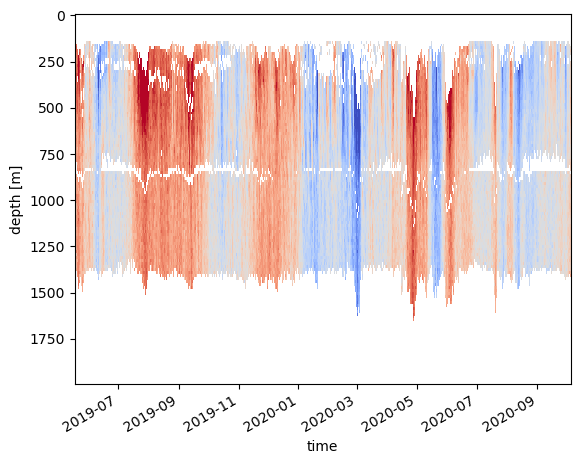

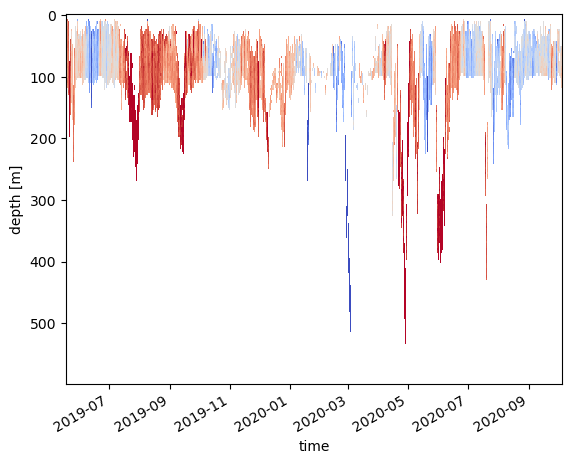

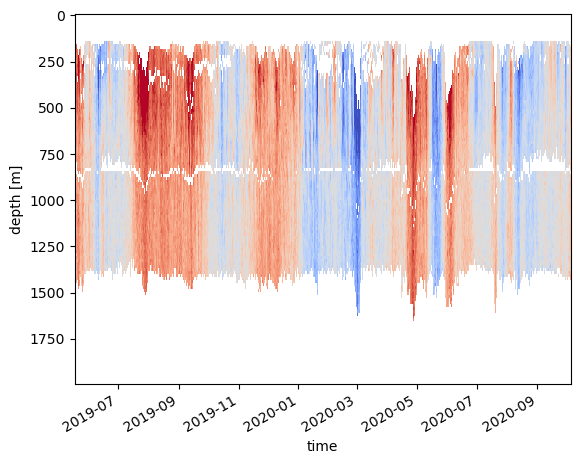

In [163]:
for v in down_interp:
    v.u.plot(yincrease=False,vmax=0.4,cmap='coolwarm',add_colorbar=False)

plt.figure()
up_interp[0].u.plot(yincrease=False,vmax=0.4,cmap='coolwarm',add_colorbar=False)
plt.figure()
for v in down_sub[0::2]:
    v.u.plot(yincrease=False,vmax=0.4,cmap='coolwarm',add_colorbar=False)

In [104]:
z_new = np.arange(0,2000,16)

In [124]:
down_interpz = [v.interp(z=z_new,method='linear') for v in down_interp]
up_interpz = [up_interp[0].interp(z=z_new,method='linear')]

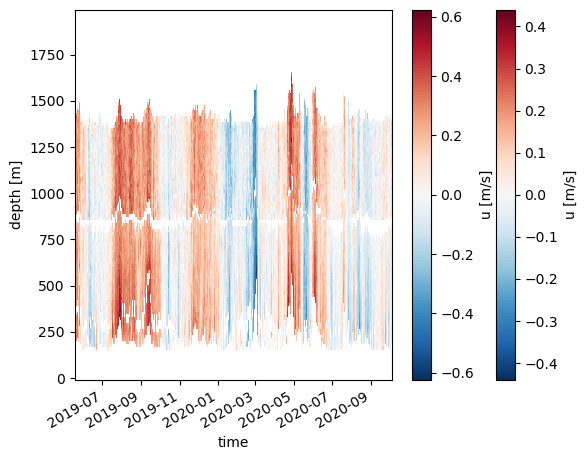

In [111]:
down_interpz[0].u.plot()
down_interpz[1].u.plot()

In [133]:
_=down_interpz[1].combine_first(down_interpz[0])
ds = up_interpz[0].combine_first(_)

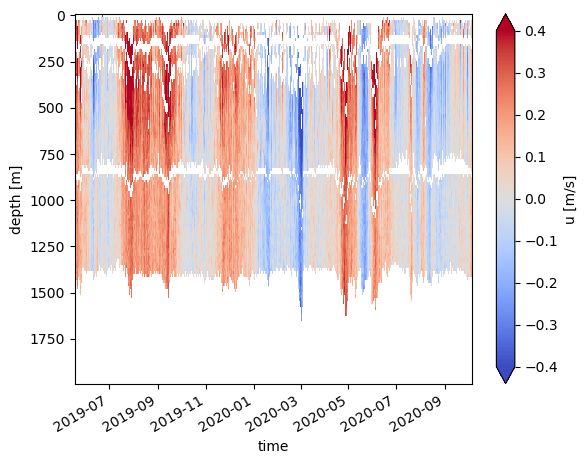

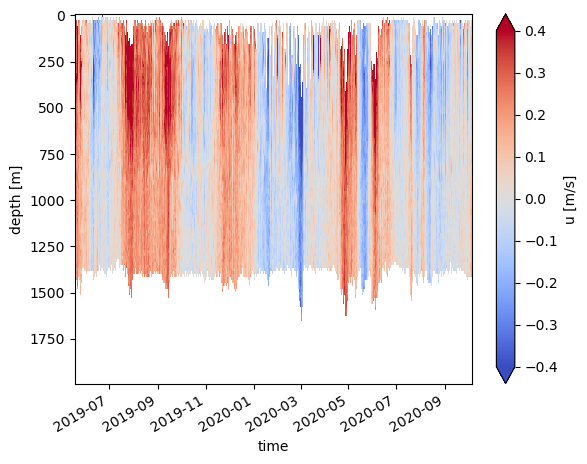

In [141]:
ds.u.plot(yincrease=False, vmax=0.4, cmap='coolwarm')

plt.figure()
ds.interpolate_na(dim='z',method='cubic').u.plot(yincrease=False, vmax=0.4, cmap='coolwarm')

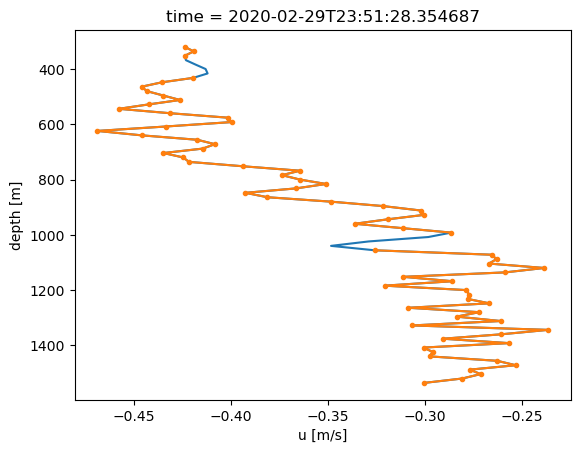

In [148]:
ds.u.interpolate_na(dim='z',method='cubic').sel(time='2020-03-01',method='nearest').plot(y='z',yincrease=False)
ds.u.sel(time='2020-03-01',method='nearest').plot(marker='.',y='z',yincrease=False)

#### Comparison with Gunnar results

In [176]:
ds_gridded = xr.open_dataset(root_dir+'gridded/'+'M1_gridded_simple_merge_gaps_filled.nc')
ds_gaps = xr.open_dataset(root_dir+'gridded/'+'M1_gridded_simple_merge.nc')
ds_gridded

<xarray.Dataset>
Dimensions:       (z: 106, time: 72966, adcp: 3)
Coordinates:
  * time          (time) datetime64[ns] 2019-05-17T16:00:00 ... 2020-10-05T08...
  * z             (z) int64 0 16 32 48 64 80 ... 1600 1616 1632 1648 1664 1680
  * adcp          (adcp) int64 3109 9408 13481
Data variables:
    u             (z, time) float64 ...
    v             (z, time) float64 ...
    xducer_depth  (adcp, time) float64 ...
    temperature   (adcp, time) float64 ...
Attributes:
    project:       NISKINe
    mooring:       M1
    lon:           -21.198829621395166
    lat:           59.101445324829214
    bottom_depth:  2881.0

In [169]:
print('Difference of step in depth: ', ds_gridded.z.diff(dim='z')-ds.z.diff(dim='z'))
print('Difference of time length: ', ds_gridded.time.size-ds.time.size)

Difference of step in depth:  <xarray.DataArray 'z' (z: 105)>
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Coordinates:
  * z        (z) int64 16 32 48 64 80 96 112 ... 1600 1616 1632 1648 1664 1680
Difference of time length:  50546


I used the original 32 minutes time step

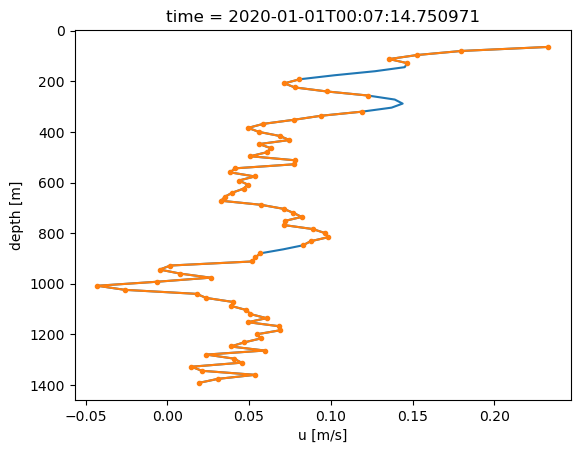

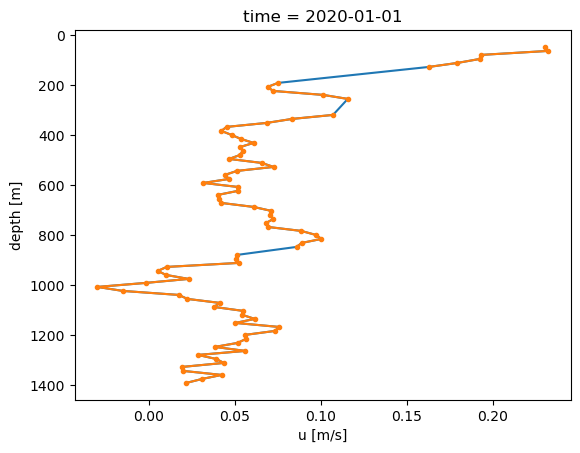

In [181]:
ds.u.interpolate_na(dim='z',method='cubic').sel(time='2020-01-01',method='nearest').plot(y='z',yincrease=False)
ds.u.sel(time='2020-01-01',method='nearest').plot(marker='.',y='z',yincrease=False)

plt.figure()
ds_gridded.u.sel(time='2020-01-01',method='nearest').plot(y='z',yincrease=False)
ds_gaps.u.sel(time='2020-01-01',method='nearest').plot(marker='.',y='z',yincrease=False)

#### Interpolating on the same grid than Gunnar:

In [173]:
down_interp = [v.interp(time=ds_gridded.time.values,method='linear') for v in down_sub if v.time.size>=a.size//2]
up_interp = [v.interp(time=ds_gridded.time.values,method='linear') for v in up_sub if v.time.size>=a.size//2]

### Overview:l gridded array

In [28]:
listf = sorted(filter(os.path.isfile,glob.glob(root_dir+'gridded/M1*')))
listf

['/Users/zcasparcohen/Documents/NISKINE/data/gridded/M1_gridded_may2019_simple_merge.nc',
 '/Users/zcasparcohen/Documents/NISKINE/data/gridded/M1_gridded_median_merge.nc',
 '/Users/zcasparcohen/Documents/NISKINE/data/gridded/M1_gridded_median_merge_gaps_filled.nc',
 '/Users/zcasparcohen/Documents/NISKINE/data/gridded/M1_gridded_simple_merge.nc',
 '/Users/zcasparcohen/Documents/NISKINE/data/gridded/M1_gridded_simple_merge_gaps_filled.nc']

In [36]:
ds_gridded = xr.open_dataset(listf[1])
ds_gridded_simple = xr.open_dataset(listf[-2])

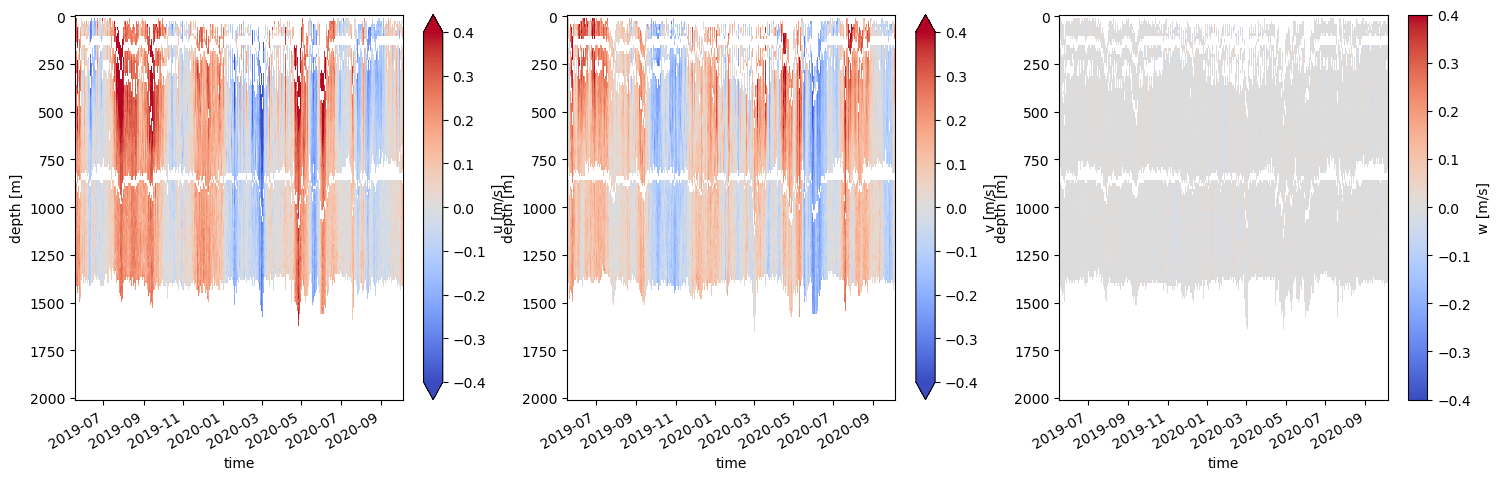

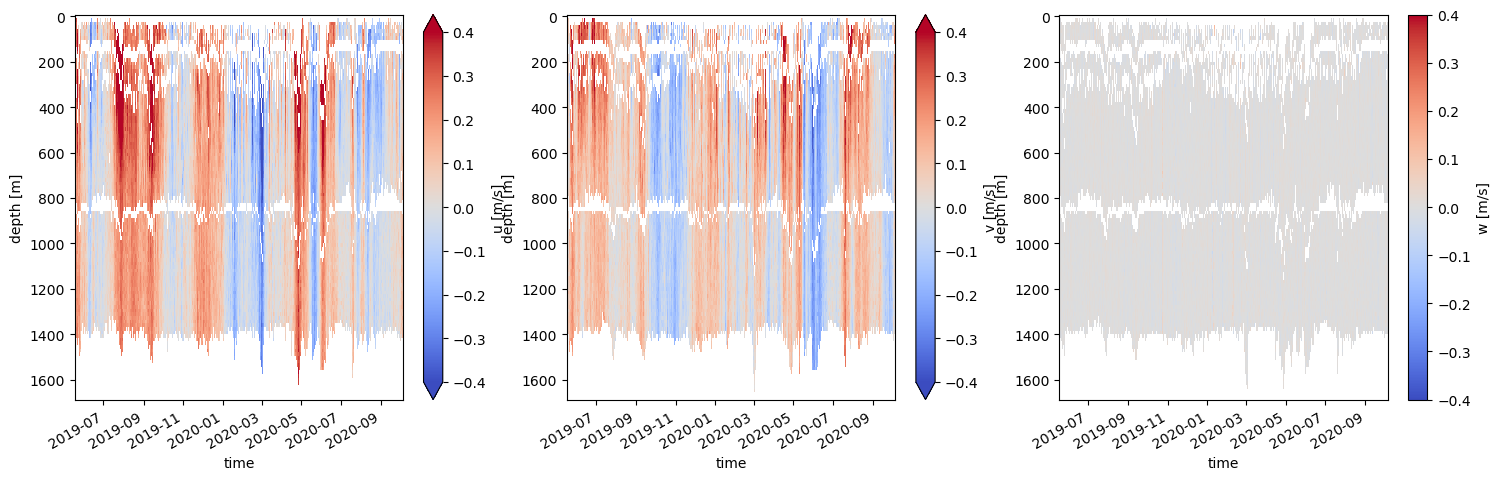

In [37]:
fig,axs=plt.subplots(1,3,figsize=(18,5))
ds_gridded.u.plot(ax=axs[0],yincrease=False,vmax=0.4,cmap='coolwarm')
ds_gridded.v.plot(ax=axs[1],yincrease=False,vmax=0.4,cmap='coolwarm')
ds_gridded.w.plot(ax=axs[2],yincrease=False,vmax=0.4,cmap='coolwarm')

fig,axs=plt.subplots(1,3,figsize=(18,5))
ds_gridded_simple.u.plot(ax=axs[0],yincrease=False,vmax=0.4,cmap='coolwarm')
ds_gridded_simple.v.plot(ax=axs[1],yincrease=False,vmax=0.4,cmap='coolwarm')
ds_gridded_simple.w.plot(ax=axs[2],yincrease=False,vmax=0.4,cmap='coolwarm')